# 03.03 - Weather Data - Compile & Impute Missing Values

 + Imports & Setup
 + Compile Raw Weather Data
 + Review Data
 + Verify and Clean Up Data
 + Imputation
 + Review Imputed Data

## Imports and Setup

In [1]:
import pathlib
import datetime
from os import PathLike
from typing import Union

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%matplotlib inline

PROJECT_DIR = pathlib.Path.cwd().parent.resolve()
RAW_DATA_DIR = PROJECT_DIR / 'data' / '01-raw' /'weather-toronto'
COMPILED_DATA_DIR = PROJECT_DIR / 'data' / '02-compiled' / 'weather-toronto'
IMPUTED_DATA_DIR = PROJECT_DIR / 'data' / '03-imputed' / 'weather-toronto'

## Compile Raw Weather Data

In [2]:
def format_weather_file(filepath: Union[str, PathLike]) -> pd.DataFrame:
    """
    Read an hourly weather data report formatted as per an Ministry of environment Weather Station file
    Rename the columns to shorter form
    Remove empty rows by looking for blanks in the Temp column
    Returns ascending date indexed DataFrame
    """
    col_renames = {'Date/Time': 'date', 'Temp (°C)': 'temp', 'Dew Point Temp (°C)':'dew_point_temp',
                   'Rel Hum (%)': 'rel_hum', 'Wind Spd (km/h)': 'wind_speed', 'Visibility (km)': 'visibility',
                   'Stn Press (kPa)': 'press', 'Hmdx': 'hmdx', 'Wind Chill': 'wind_chill', 'Weather': 'weather'}
    keeper_cols = list(col_renames.values())
    
    df = pd.read_csv(filepath, sep=',', parse_dates=['Date/Time'], skiprows=15)
    df.rename(columns=col_renames, inplace=True)
    df = df[keeper_cols]
    df.set_index('date', inplace=True, drop=True)
    df.dropna(subset =['temp'], inplace=True)
    df.sort_index(inplace=True)

    return df

In [3]:
# Get the raw directory filepaths
csv_fps = [fp for fp in RAW_DATA_DIR.iterdir() if fp.is_file()]
# create multiple dfs from each filepath
dfs = [format_weather_file(fp) for fp in csv_fps]
# combine into a single DataFrame and save in the interim dir
df = pd.concat(dfs, axis=0)
# We need to drop duplicate index values due to the woverlap in the weather data
df = df.loc[~df.index.duplicated()]
df.sort_index(inplace=True)
df.to_csv(COMPILED_DATA_DIR / "weather_toronto.csv")

## Review Data

In [4]:
dtypes = {'temp': np.float64, 'dew_point_temp':np.float64, 'rel_hum':np.float64,
          'wind_speed': np.float64, 'visibility': np.float64, 'press': np.float64,
          'hmdx': np.float64, 'wind_chill': np.float64, 'weather': np.object}

df = pd.read_csv(COMPILED_DATA_DIR / "weather_toronto.csv", parse_dates=['date'],
                 dtype=dtypes, index_col=0, infer_datetime_format=True)

df.head()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather
date,,,,,,,,,
1953-01-01 00:00:00,-5.6,-6.7,93.0,10.0,25.0,99.44,NaN,-10.0,Cloudy
1953-01-01 01:00:00,-5.6,-9.4,71.0,3.0,25.0,99.46,NaN,-7.0,Cloudy
1953-01-01 02:00:00,-5.0,-8.9,72.0,0.0,19.3,99.43,NaN,NaN,Cloudy
1953-01-01 03:00:00,-5.0,-7.8,79.0,0.0,19.3,99.56,NaN,NaN,Cloudy
1953-01-01 04:00:00,-4.4,-7.2,80.0,0.0,19.3,99.55,NaN,NaN,Cloudy


In [5]:
df.tail()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather
date,,,,,,,,,
2019-06-11 19:00:00,19.4,2.5,32.0,16.0,24.1,99.88,NaN,NaN,Clear
2019-06-11 20:00:00,18.0,1.8,33.0,9.0,24.1,99.89,NaN,NaN,NaN
2019-06-11 21:00:00,17.0,2.7,38.0,13.0,24.1,99.89,NaN,NaN,NaN
2019-06-11 22:00:00,14.7,4.0,48.0,11.0,24.1,99.92,NaN,NaN,Clear
2019-06-11 23:00:00,14.0,4.4,52.0,12.0,24.1,99.94,NaN,NaN,NaN


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 582248 entries, 1953-01-01 00:00:00 to 2019-06-11 23:00:00
Data columns (total 9 columns):
temp              582248 non-null float64
dew_point_temp    582213 non-null float64
rel_hum           582210 non-null float64
wind_speed        582246 non-null float64
visibility        582248 non-null float64
press             582239 non-null float64
hmdx              77410 non-null float64
wind_chill        143782 non-null float64
weather           552716 non-null object
dtypes: float64(8), object(1)
memory usage: 44.4+ MB


## Verify and Clean Up Data

The data should cover every hour from midnight on 1 January 1953, to 23:00 on 11 June 2019

There should be no gaps in the temperature data as this is a major driver of pwer demand

In [7]:
# Firstly, make sure the datetime index covers every hour from start to finish  
# create an empty DataFrame that starts at the data start date and ends at the data end date
start = df.index.values[0] ; end = df.index.values[-1] ; freq = '1h'
full_index = pd.date_range(freq=freq, start=start, end=end)
mt_df = pd.DataFrame([np.NaN]* len(full_index), index=full_index)
# Concat this fully indexed mt dataFrame to the data dataFrame with outer join
concat_df = pd.concat([mt_df, df], axis=1,join='outer', sort=True)
# find any places where the temp data is a NaN
gaps = concat_df[concat_df['temp'].isnull()].index.values
len(gaps)

185

In [8]:
gaps

array(['1953-06-30T04:00:00.000000000', '1953-08-24T19:00:00.000000000',
       '1953-12-12T23:00:00.000000000', '1955-11-28T17:00:00.000000000',
       '1955-11-30T07:00:00.000000000', '1957-06-26T02:00:00.000000000',
       '1957-12-29T06:00:00.000000000', '1983-05-29T17:00:00.000000000',
       '1990-01-23T12:00:00.000000000', '1990-01-23T13:00:00.000000000',
       '1990-01-23T14:00:00.000000000', '1990-01-23T15:00:00.000000000',
       '1990-01-23T16:00:00.000000000', '1994-02-01T00:00:00.000000000',
       '1994-02-01T01:00:00.000000000', '1994-03-27T02:00:00.000000000',
       '1994-05-25T08:00:00.000000000', '1994-07-31T19:00:00.000000000',
       '1994-07-31T20:00:00.000000000', '1994-07-31T21:00:00.000000000',
       '1994-07-31T22:00:00.000000000', '1994-07-31T23:00:00.000000000',
       '1994-08-01T00:00:00.000000000', '1994-08-01T01:00:00.000000000',
       '1995-07-01T03:00:00.000000000', '1995-07-04T06:00:00.000000000',
       '1995-08-02T20:00:00.000000000', '1995-08-02

This looks pretty good - Only 185 missing values out of 582432 posiible instances ~ 0.03%

Furthermore, by inspection of the miossing points above, there are no major consecutive gaps

Based on the above two points, I will impute thropugh linear interpolation.

## Imputation

In [9]:
df = concat_df.copy()
df.drop(columns=[0], inplace=True)
interp_cols = ['temp', 'dew_point_temp', 'rel_hum', 'wind_speed', 'visibility', 'press']
df[interp_cols] = df[interp_cols].interpolate(method='linear', limit_direction='forward', axis=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 582433 entries, 1953-01-01 00:00:00 to 2019-06-11 23:00:00
Data columns (total 9 columns):
temp              582433 non-null float64
dew_point_temp    582433 non-null float64
rel_hum           582433 non-null float64
wind_speed        582433 non-null float64
visibility        582433 non-null float64
press             582433 non-null float64
hmdx              77410 non-null float64
wind_chill        143782 non-null float64
weather           552716 non-null object
dtypes: float64(8), object(1)
memory usage: 44.4+ MB


## Review Imputed Data

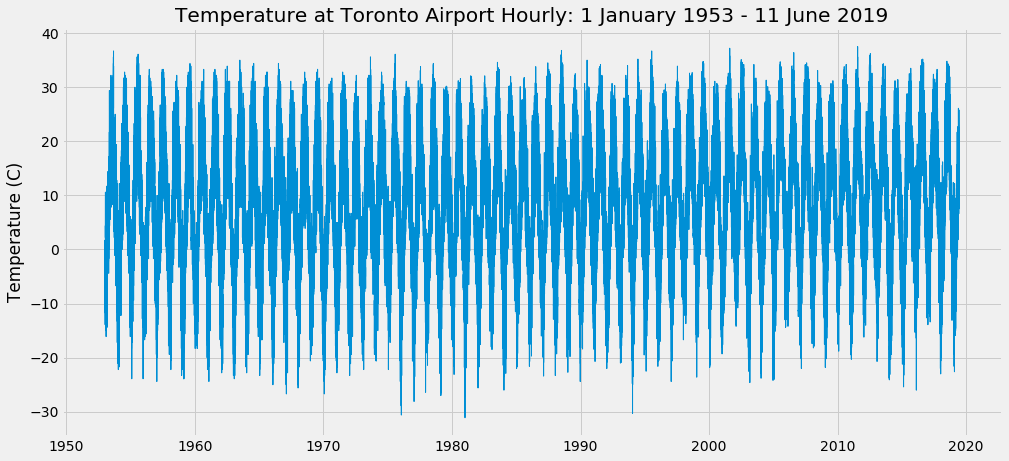

In [10]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df['temp'], linewidth=1)
ax.set_ylabel('Temperature (C)')
ax.set_title('Temperature at Toronto Airport Hourly: 1 January 1953 - 11 June 2019')
plt.show();

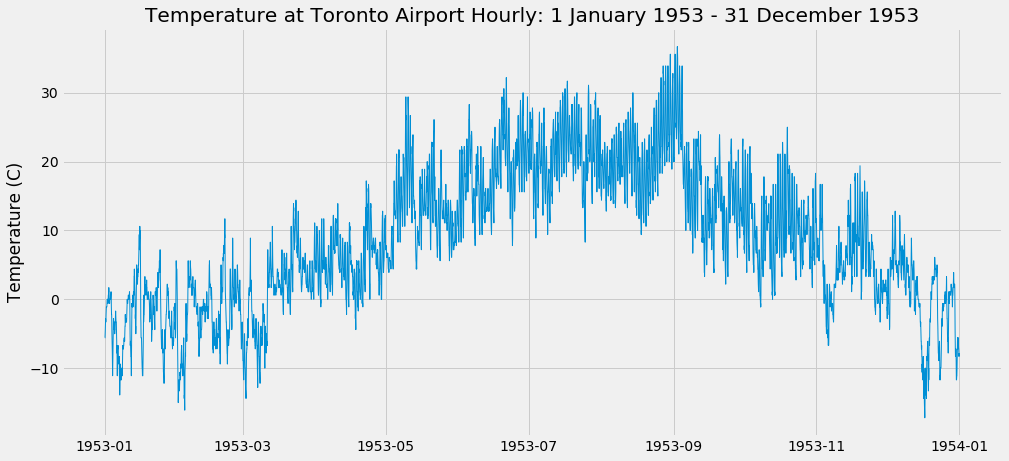

In [11]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df.loc['1953-01-01':'1953-12-31', 'temp'], linewidth=1)
ax.set_ylabel('Temperature (C)')
ax.set_title('Temperature at Toronto Airport Hourly: 1 January 1953 - 31 December 1953')
plt.show();

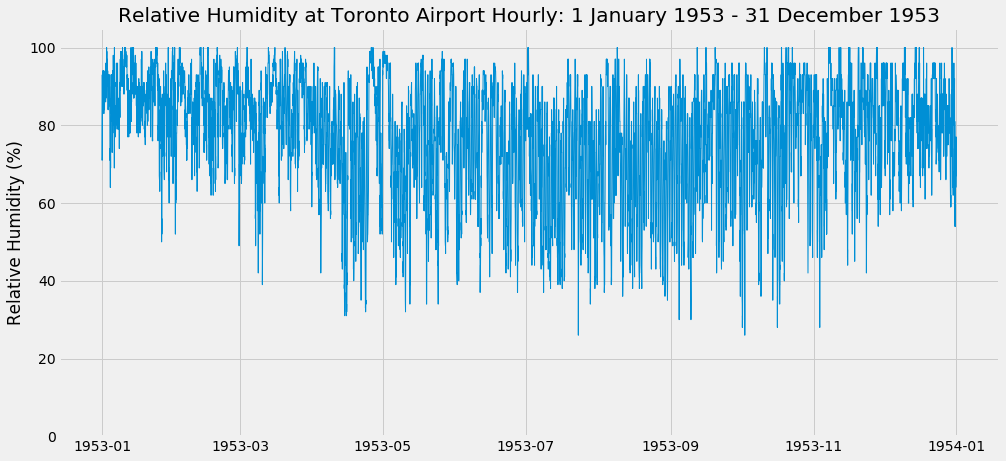

In [12]:
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(df.loc['1953-01-01':'1953-12-31', 'rel_hum'], linewidth=1)
ax.set_ylabel('Relative Humidity (%)')
ax.set_ylim((0,105))
ax.set_title('Relative Humidity at Toronto Airport Hourly: 1 January 1953 - 31 December 1953')
plt.show();

In [13]:
df.to_csv(IMPUTED_DATA_DIR / "weather_toronto.csv")

In [14]:
dtypes = {'temp': np.float64, 'dew_point_temp':np.float64, 'rel_hum':np.float64,
          'wind_speed': np.float64, 'visibility': np.float64, 'press': np.float64,
          'hmdx': np.float64, 'wind_chill': np.float64, 'weather': np.object}
df = pd.read_csv(IMPUTED_DATA_DIR / "weather_toronto.csv", parse_dates=True,
                 dtype=dtypes, index_col=0, infer_datetime_format=True)

df.head()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather
1953-01-01 00:00:00,-5.6,-6.7,93.0,10.0,25.0,99.44,NaN,-10.0,Cloudy
1953-01-01 01:00:00,-5.6,-9.4,71.0,3.0,25.0,99.46,NaN,-7.0,Cloudy
1953-01-01 02:00:00,-5.0,-8.9,72.0,0.0,19.3,99.43,NaN,NaN,Cloudy
1953-01-01 03:00:00,-5.0,-7.8,79.0,0.0,19.3,99.56,NaN,NaN,Cloudy
1953-01-01 04:00:00,-4.4,-7.2,80.0,0.0,19.3,99.55,NaN,NaN,Cloudy


In [15]:
df.tail()

,temp,dew_point_temp,rel_hum,wind_speed,visibility,press,hmdx,wind_chill,weather
2019-06-11 19:00:00,19.4,2.5,32.0,16.0,24.1,99.88,NaN,NaN,Clear
2019-06-11 20:00:00,18.0,1.8,33.0,9.0,24.1,99.89,NaN,NaN,NaN
2019-06-11 21:00:00,17.0,2.7,38.0,13.0,24.1,99.89,NaN,NaN,NaN
2019-06-11 22:00:00,14.7,4.0,48.0,11.0,24.1,99.92,NaN,NaN,Clear
2019-06-11 23:00:00,14.0,4.4,52.0,12.0,24.1,99.94,NaN,NaN,NaN


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 582433 entries, 1953-01-01 00:00:00 to 2019-06-11 23:00:00
Data columns (total 9 columns):
temp              582433 non-null float64
dew_point_temp    582433 non-null float64
rel_hum           582433 non-null float64
wind_speed        582433 non-null float64
visibility        582433 non-null float64
press             582433 non-null float64
hmdx              77410 non-null float64
wind_chill        143782 non-null float64
weather           552716 non-null object
dtypes: float64(8), object(1)
memory usage: 44.4+ MB
